In [1]:
def read_documents(file_path: str):
    documents = []
    sentence = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            if '\t' in line:
                line = line[:-1]
                word, label = line.split('\t')
                # We ignore case
                word = word.lower()
                sentence.append((word, label))
            else:
                documents.append(sentence)
                sentence = []
    if len(sentence) > 0:
        documents.append(sentence)
    return documents

def convert_to_array(documents):
    X = []
    y = []
    for sentence in documents:
        X_sentence = []
        y_sentence = []
        for word, label in sentence:
            X_sentence.append(word)
            y_sentence.append(label)
        X.append(X_sentence)
        y.append(y_sentence)

    return X, y


In [2]:
train_documents = read_documents('dataset/nergrit_ner-grit/train_preprocess.txt')
validation_documents = read_documents('dataset/nergrit_ner-grit/valid_preprocess.txt')
test_documents = read_documents('dataset/nergrit_ner-grit/test_preprocess_masked_label.txt')

In [3]:
X_train, y_train = convert_to_array(train_documents)
X_validation, y_validation = convert_to_array(validation_documents)
X_test, y_test = convert_to_array(test_documents)

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

def build_tokenizer(X):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)
    return tokenizer

In [5]:
word_tokenizer = build_tokenizer(X_train + X_validation + X_test)
label_tokenizer = build_tokenizer(y_train)

In [6]:
X_train_encoded = word_tokenizer.texts_to_sequences(X_train)
y_train_encoded = label_tokenizer.texts_to_sequences(y_train)

X_validation_encoded = word_tokenizer.texts_to_sequences(X_validation)
y_validation_encoded = label_tokenizer.texts_to_sequences(y_validation)

X_test_encoded = word_tokenizer.texts_to_sequences(X_test)
y_test_encoded = label_tokenizer.texts_to_sequences(y_test)

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQ_LENGTH = max([len(x) for x in train_documents])

def pad_sequence_fn(arr):
    return pad_sequences(arr, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [8]:
X_train_padded = pad_sequence_fn(X_train_encoded)
y_train_padded = pad_sequence_fn(y_train_encoded)

X_validation_padded = pad_sequence_fn(X_validation_encoded)
y_validation_padded = pad_sequence_fn(y_validation_encoded)

X_test_padded = pad_sequence_fn(X_test_encoded)
y_test_padded = pad_sequence_fn(y_test_encoded)

In [9]:
# user pretrained word2vec model
# https://github.com/deryrahman/word2vec-bahasa-indonesia

import gensim

path = 'idwiki_word2vec_100.model'
word2vec = gensim.models.word2vec.Word2Vec.load(path)

In [10]:
import numpy as np

EMBEDDING_SIZE  = 100
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

for word, index in word_tokenizer.word_index.items():
    try:
        embedding_weights[index, :] = word2vec.wv[word]
    except KeyError:
        pass


In [11]:
from tensorflow.keras.utils import to_categorical

y_train_categorical = to_categorical(y_train_padded)
y_validation_categorical = to_categorical(y_validation_padded)
y_test_categorical = to_categorical(y_test_padded)

In [12]:
import tensorflow.keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TimeDistributed


# total number of tags
NUM_CLASSES = y_train_categorical.shape[2]

# create vanilla RNN architecture
rnn_model = Sequential()
rnn_model.add(
    Embedding(
        input_dim=VOCABULARY_SIZE, # vocabulary size - number of unique words in data
        output_dim=EMBEDDING_SIZE, # length of vector with which each word is represented
        input_length=MAX_SEQ_LENGTH, # length of input sequence
        weights=[embedding_weights],
        trainable=False, # False - don't update the embeddings
    )
)

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64,
    return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

rnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[get_f1]),
rnn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 216, 100)          1170900   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 216, 64)           10560     
_________________________________________________________________
time_distributed (TimeDistri (None, 216, 8)            520       
Total params: 1,181,980
Trainable params: 11,080
Non-trainable params: 1,170,900
_________________________________________________________________


2022-03-27 21:05:37.143024: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-27 21:05:37.144338: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
rnn_training = \
    rnn_model.fit(
        X_train_padded,
        y_train_categorical,
        batch_size=1,
        epochs=1,
        validation_data=(X_validation_padded, y_validation_categorical),
    )

2022-03-27 21:05:37.720980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1672/1672 [==============================] - 195s 116ms/step - loss: 0.1125 - get_f1: 0.9666 - val_loss: 0.0623 - val_get_f1: 0.9800


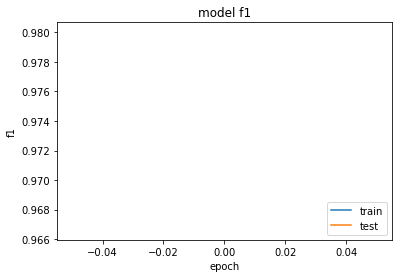

In [15]:
# visualise training history
from matplotlib import pyplot as plt

plt.plot(rnn_training.history['get_f1'])
plt.plot(rnn_training.history['val_get_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [16]:
# Save the model
from tensorflow.keras.models import save_model

filepath = './rnn.model'
save_model(rnn_model, filepath)

2022-03-27 21:08:54.887562: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./rnn.model/assets


In [17]:
def invert_labels(preds):
    labels = []

    i2label_dict = dict(label_tokenizer.index_word)
    i2label_dict[0] = '-'
    for j, sentence in enumerate(preds):
        label = []
        for w_label in sentence:
            max = -1
            maxi = 0
            for i, labelval in enumerate(w_label):
                if i == 0:
                    continue
                if labelval > max:
                    max = labelval
                    maxi = i
            if maxi != 0:
                label.append(i2label_dict[maxi].upper())
        leng = len(test_documents[j])
        labels.append(label[-leng:])

    return labels

In [20]:
y_test_preds = rnn_model.predict(X_test_padded)

In [21]:
y_test_inverted_preds = invert_labels(y_test_preds)

In [22]:
import pandas as pd
import numpy as np
np.set_string_function(lambda x: repr(list(x)), repr=False)
np.set_printoptions(linewidth=np.inf)

result_df = pd.DataFrame({'label': y_test_inverted_preds}).reset_index()
result_df.to_csv('pred.txt', index=False)